# Sistem Case-Based Reasoning (CBR) untuk Analisis Putusan Pidana Militer

### **Dokumentasi Proyek Penelitian**

**Abstrak:**

Proyek ini bertujuan untuk merancang dan mengimplementasikan sistem *Case-Based Reasoning* (CBR) untuk menganalisis dan merekomendasikan putusan pengadilan dalam domain pidana militer. Sistem ini memanfaatkan data putusan riil dari Direktori Putusan Mahkamah Agung Republik Indonesia. Alur kerja mencakup empat tahap utama siklus CBR:  
(1) **Case Base Building**, yang mencakup *web scraping* untuk mengumpulkan minimal 30 dokumen putusan, konversi PDF ke teks menggunakan *PyMuPDF*, serta pembersihan teks untuk menghasilkan file teks terstruktur;  
(2) **Case Representation**, yang mencakup ekstraksi metadata (nomor perkara, tanggal, pasal, pihak) dan konten kunci (ringkasan fakta, amar putusan), serta analisis eksploratif data (*Exploratory Data Analysis / EDA*) untuk mengidentifikasi pola-pola dalam data;  
(3) **Case Retrieval**, dengan mengimplementasikan tiga model retrieval yaitu TF-IDF (*Term Frequency-Inverse Document Frequency*) + *Cosine Similarity*, SVM, dan BERT (*IndoBERT embeddings*), serta evaluasi performa menggunakan metrik seperti MAP@k, Accuracy, Precision@k, Recall@k, dan F1@k;  
(4) **Solution Reuse**, yaitu memprediksi amar putusan berdasarkan *majority vote* dari kasus-kasus serupa, dengan uji coba manual terhadap lima kueri baru.

- **Domain**: Pidana Militer  
- **Metodologi Retrieval**: TF-IDF (*Term Frequency-Inverse Document Frequency*), SVM, BERT (*IndoBERT*)  
- **Tools**: Python, Pandas, Scikit-learn, BeautifulSoup, PyMuPDF, Transformers, Matplotlib, Seaborn, WordCloud


https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1.html

## **Tahap 1: Persiapan dan Akuisisi Data**

Pada tahap awal ini, kita akan mempersiapkan lingkungan kerja dengan mengimpor semua pustaka yang diperlukan. Selanjutnya, kita akan mengakuisisi data mentah dengan melakukan *web scraping* langsung dari situs Direktori Putusan Mahkamah Agung.

### **1.1. Impor Pustaka**

In [49]:
import os
import re
import requests
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
import random
import logging

# --- Pustaka untuk Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# --- Pustaka untuk Machine Learning (sklearn) ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import numpy as np

# --- Pustaka Tambahan ---
from collections import Counter
import json

# --- Pengaturan Visualisasi ---
%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

print("Pustaka berhasil di-impor.")

Pustaka berhasil di-impor.


### **1.2. Pengumpulan Data (Web Scraping)**

Pada tahap ini, kita akan mengumpulkan data putusan pidana militer secara otomatis dengan menjelajahi halaman direktori situs Mahkamah Agung untuk mendapatkan URL putusan, kemudian mengunduh dan membersihkan teks dari file PDF. Fungsi `scrape_listing_pages` digunakan untuk mengumpulkan URL putusan, dan fungsi `scrape_and_clean_putusan` mengekstrak serta membersihkan teks dari setiap PDF.

In [2]:
def scrape_listing_pages(start_url, max_putusan):
    """
    Menjelajahi halaman direktori untuk mengumpulkan semua URL putusan.
    """
    all_decision_urls = set()
    current_page_url = start_url
    
    while current_page_url and len(all_decision_urls) < max_putusan:
        print(f"🔎 Menjelajahi halaman daftar: {current_page_url}")
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
            response = requests.get(current_page_url, headers=headers, timeout=20)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Menggunakan selector yang lebih umum untuk mencakup lebih banyak variasi
            links_on_page = soup.select('div.spost a[href*="/direktori/putusan/"]')
            if not links_on_page:
                print("  ⚠️ Tidak ada link putusan ditemukan di halaman ini. Berhenti.")
                break

            for link in links_on_page:
                if len(all_decision_urls) < max_putusan:
                    all_decision_urls.add(link['href'])
                else:
                    break
            
            print(f"  --> Terkumpul {len(all_decision_urls)} URL unik.")

            next_link_element = soup.select_one('a[rel="next"]')
            if next_link_element and next_link_element.get('href') and next_link_element.get('href') != '#':
                current_page_url = next_link_element['href']
                print(f"  ➡️ Pindah ke halaman berikutnya: {current_page_url}")
                time.sleep(random.uniform(1.5, 3.5)) # PERBAIKAN: Jeda acak yang lebih sopan
            else:
                print("  🏁 Tombol 'Next' yang valid tidak ditemukan. Penjelajahan selesai.")
                current_page_url = None

        except Exception as e:
            print(f"❌ Error saat menjelajahi halaman daftar: {e}")
            break
            
    return list(all_decision_urls)

def scrape_and_clean_putusan(url, max_retries=3):
    """
    Fungsi scraping individual yang disempurnakan dengan retry logic dan pesan error yang lebih jelas.
    """
    for attempt in range(max_retries):
        try:
            # Jeda kecil sebelum setiap request
            time.sleep(random.uniform(1, 2))
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
            
            # Mengunduh halaman utama putusan
            response_page = requests.get(url, headers=headers, timeout=45)
            response_page.raise_for_status()
            soup = BeautifulSoup(response_page.content, 'html.parser')
            
            # PERBAIKAN: Logika pencarian link PDF yang lebih andal
            pdf_link_element = soup.select_one('a[href*="/download_file/"][href*="/pdf/"]')
            if not pdf_link_element:
                print(f"  ❌ Gagal: Link unduh PDF tidak ditemukan di halaman. (Mungkin tidak dipublikasi)")
                return None
            
            pdf_url = pdf_link_element['href']
            if not pdf_url.startswith('http'):
                pdf_url = 'https://putusan3.mahkamahagung.go.id' + pdf_url
            
            # Mengunduh file PDF
            response_pdf = requests.get(pdf_url, headers=headers, timeout=90) # Timeout lebih lama untuk PDF
            response_pdf.raise_for_status()
            
            # Ekstraksi dan Validasi Teks
            with fitz.open(stream=response_pdf.content, filetype="pdf") as pdf_document:
                full_text = "".join(page.get_text() for page in pdf_document)
            
            # PERBAIKAN: Validasi keutuhan teks
            if len(full_text.split()) < 150: # Anggap tidak utuh jika kurang dari 150 kata
                print(f"  ❌ Gagal: Teks yang diekstrak terlalu pendek ({len(full_text.split())} kata). Kemungkinan file rusak.")
                return None

            # Pembersihan Teks
            cleaned_text = full_text.lower()
            lines = cleaned_text.split('\n')
            cleaned_lines = [line for line in lines if not line.strip().isdigit() and "demi keadilan" not in line and "mahkamah agung" not in line and "disclaimer" not in line]
            cleaned_text = "\n".join(cleaned_lines)
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
            
            # Jika semua berhasil, kembalikan teks dan keluar dari loop retry
            return cleaned_text
            
        except requests.exceptions.RequestException as e:
            print(f"  ⚠️ Peringatan Jaringan pada percobaan {attempt + 1}/{max_retries}: {e}")
            if attempt + 1 == max_retries:
                print(f"  ❌ Gagal total setelah {max_retries} percobaan.")
                return None
            time.sleep(5) # Tunggu 5 detik sebelum mencoba lagi
        except Exception as e:
            print(f"  ❌ Error tak terduga: {e}")
            return None # Untuk error lain, langsung gagal
    return None

# 1. Kumpulkan semua URL dari halaman direktori
start_url = 'https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1.html'
MAX_PUTUSAN_TO_SCRAPE = 100 # Set ke jumlah yang Anda butuhkan (misal: 100 untuk memenuhi syarat >= 30)

print(f"--- TAHAP 1: Mengumpulkan max {MAX_PUTUSAN_TO_SCRAPE} URL ---")
urls_to_process = scrape_listing_pages(start_url, max_putusan=MAX_PUTUSAN_TO_SCRAPE)
print(f"\n✅ Selesai mengumpulkan URL. Total ditemukan: {len(urls_to_process)}")

# 2. Proses (Scrape & Clean) setiap URL yang ditemukan
if urls_to_process:
    raw_data_path = '../data/raw'
    os.makedirs(raw_data_path, exist_ok=True) 

    print(f"\n--- TAHAP 2: Memproses {len(urls_to_process)} URL ---")
    for i, url in enumerate(urls_to_process):
        case_id = f"mil_case_{i+1:03d}"
        print(f"\nMemproses {case_id}: {url}...")
        
        file_path = os.path.join(raw_data_path, f'{case_id}.txt')
        if os.path.exists(file_path):
            print(f"  ⏩ File sudah ada, dilewati.")
            continue

        cleaned_text = scrape_and_clean_putusan(url)

        if cleaned_text:
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(cleaned_text)
            print(f"  ✅ Berhasil menyimpan ke {file_path}")
        else:
            # Pesan error spesifik sudah dicetak di dalam fungsi
            print(f"  Gagal memproses {case_id}.")
            
    print("\n\n--- Proses scraping dan pembersihan keseluruhan selesai. ---")
else:
    print("\nTidak ada URL untuk diproses. Skrip berhenti.")

--- TAHAP 1: Mengumpulkan max 100 URL ---
🔎 Menjelajahi halaman daftar: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1.html
  --> Terkumpul 24 URL unik.
  ➡️ Pindah ke halaman berikutnya: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/2.html
🔎 Menjelajahi halaman daftar: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/2.html
  --> Terkumpul 47 URL unik.
  ➡️ Pindah ke halaman berikutnya: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/3.html
🔎 Menjelajahi halaman daftar: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/3.html
  --> Terkumpul 70 URL unik.
  ➡️ Pindah ke halaman berikutnya: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/4.html
🔎 Menjelajahi halaman daftar: https://putusan3.mahkamahagung.go.id/direktori/index/kategori/pidana-militer-1/page/4.html
  --> Terkumpul 

## **Tahap 2: Representasi Kasus dan Analisis Data Eksploratif (EDA)**

Setelah data mentah terkumpul, tahap ini bertujuan untuk mengubah teks tidak terstruktur menjadi format data terstruktur (CSV). Kita akan menggunakan *Regular Expressions* (Regex) untuk mengekstrak fitur-fitur penting. Setelah itu, kita akan melakukan EDA untuk memahami karakteristik korpus data kita melalui statistik deskriptif dan visualisasi.

### **2.1. Ekstraksi Fitur dari Teks (Case Representation)**

Fungsi `extract_features` akan membaca setiap file teks yang telah dibersihkan dan mengekstrak informasi spesifik seperti nomor perkara, identitas terdakwa, dakwaan, ringkasan fakta, dan amar putusan.

In [3]:
def extract_features(text, case_id):
    """Ekstrak fitur dengan tambahan tanggal, pasal, dan pihak."""
    features = {'case_id': case_id}
    patterns = {
        'no_perkara': r'p\s*u\s*t\s*u\s*s\s*a\s*n\s+nomor\s*:?\s*([\w\./-]+)',
        'tanggal': r'tanggal\s+putusan\s*:?\s*([\d\s\w-]+)',  # Tambah tanggal
        'pasal': r'pasal\s+([\d\s\w-]+?)(?:\s+dari|\s*menimbang)',  # Tambah pasal
        'pihak': r'(oditur\s+militer.*?)(?:vs\.?|melawan)\s*([^\n]+)',  # Tambah pihak
        'terdakwa_nama': r'nama\s+lengkap\s*:\s*([\w\s\.]+?)\s*pangkat',
        'terdakwa_pangkat_nrp': r'pangkat(?:/korps)?,\s*nrp\s*:\s*([\w\s\(\)\.,\/]+?)\s*jabatan',
        'terdakwa_kesatuan': r'kesatuan\s*:\s*([\w\s\/\d\.-]+?)\s*tempat,?\s*tanggal\s*lahir',
        'dakwaan_full': r'(surat\s+dakwaan\s+oditur\s+militer.*?)(?:membaca|tuntutan)',
        'ringkasan_fakta': r'(fakta\s+hukum\s+yang\s+terungkap\s+di\s+persidangan.*?)(bahwa\s+berdasarkan\s+fakta-fakta\s+hukum\s+tersebut\s+di\s+atas)',
        'amar_putusan': r'm\s*e\s*n\s*g\s*a\s*d\s*i\s*l\s*i\s*:\s*(.*?)demikian\s+diputuskan'
    }
    
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        features[key] = re.sub(r'\s+', ' ', match.group(1).strip()) if match else None
    
    features['full_text'] = text
    
    # Feature engineering: Bag-of-words
    words = text.split()
    features['word_count'] = len(words)
    word_freq = Counter(words)
    features['top_5_words'] = json.dumps(dict(word_freq.most_common(5)))
    
    return features

# --- Eksekusi Ekstraksi Fitur ---
all_cases = []
raw_files_path = '../data/raw'
if os.path.exists(raw_files_path):
    raw_files = [f for f in os.listdir(raw_files_path) if f.endswith('.txt')]
    for filename in raw_files:
        case_id = filename.replace('.txt', '')
        print(f"Mengekstrak fitur dari: {filename}")
        with open(os.path.join(raw_files_path, filename), 'r', encoding='utf-8') as f:
            text = f.read()
        case_features = extract_features(text, case_id)
        all_cases.append(case_features)

    df_cases = pd.DataFrame(all_cases)
    os.makedirs('../data/processed', exist_ok=True)
    df_cases.to_csv('../data/processed/cases.csv', index=False)
    print("\n✅ Ekstraksi fitur selesai. Data disimpan di ../data/processed/military_cases.csv")
else:
    print(f"❌ Direktori '{raw_files_path}' tidak ditemukan.")

Mengekstrak fitur dari: mil_case_001.txt
Mengekstrak fitur dari: mil_case_002.txt
Mengekstrak fitur dari: mil_case_003.txt
Mengekstrak fitur dari: mil_case_004.txt
Mengekstrak fitur dari: mil_case_006.txt
Mengekstrak fitur dari: mil_case_007.txt
Mengekstrak fitur dari: mil_case_008.txt
Mengekstrak fitur dari: mil_case_009.txt
Mengekstrak fitur dari: mil_case_010.txt
Mengekstrak fitur dari: mil_case_011.txt
Mengekstrak fitur dari: mil_case_012.txt
Mengekstrak fitur dari: mil_case_013.txt
Mengekstrak fitur dari: mil_case_014.txt
Mengekstrak fitur dari: mil_case_016.txt
Mengekstrak fitur dari: mil_case_017.txt
Mengekstrak fitur dari: mil_case_018.txt
Mengekstrak fitur dari: mil_case_019.txt
Mengekstrak fitur dari: mil_case_020.txt
Mengekstrak fitur dari: mil_case_021.txt
Mengekstrak fitur dari: mil_case_022.txt
Mengekstrak fitur dari: mil_case_023.txt
Mengekstrak fitur dari: mil_case_024.txt
Mengekstrak fitur dari: mil_case_025.txt
Mengekstrak fitur dari: mil_case_027.txt
Mengekstrak fitu

### **2.2. Analisis Data Eksploratif (EDA)**

EDA membantu kita memahami data sebelum membangun model. Kita akan memeriksa struktur data, data yang hilang (*missing values*), distribusi panjang dokumen, dan kata-kata yang paling sering muncul.

In [10]:
# Muat data yang sudah diproses untuk analisis
try:
    df = pd.read_csv('../data/processed/cases.csv')
    print("--- Informasi Dasar DataFrame ---")
    df.info()
    
    print("\n--- Contoh Data (Kasus Pertama) ---")
    display(df.head(1).T)
except FileNotFoundError:
    print("❌ File 'cases.csv' tidak ditemukan. Jalankan sel sebelumnya.")

--- Informasi Dasar DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   case_id               81 non-null     object 
 1   no_perkara            74 non-null     object 
 2   tanggal               0 non-null      float64
 3   pasal                 20 non-null     object 
 4   pihak                 32 non-null     object 
 5   terdakwa_nama         61 non-null     object 
 6   terdakwa_pangkat_nrp  46 non-null     object 
 7   terdakwa_kesatuan     52 non-null     object 
 8   dakwaan_full          56 non-null     object 
 9   ringkasan_fakta       1 non-null      object 
 10  amar_putusan          48 non-null     object 
 11  full_text             81 non-null     object 
 12  word_count            81 non-null     int64  
 13  top_5_words           81 non-null     object 
dtypes: float64(1), int64(1), object(12)
memory

,0
case_id,mil_case_001
no_perkara,58-k/pm.ii-09/ad/iii/2025
tanggal,NaN
pasal,NaN
pihak,oditur militer nomor sdak/26/k/ad/ii-08/iii/20...
terdakwa_nama,boby pranata ginting
terdakwa_pangkat_nrp,"prada, 31200725860500"
terdakwa_kesatuan,yonarmed 13/nanggala/1/1 kostrad
dakwaan_full,surat dakwaan oditur militer nomor sdak/26/k/a...
ringkasan_fakta,NaN


#### **Visualisasi Data Hilang (*Missing Values*)**

Heatmap adalah cara efektif untuk melihat kolom mana yang seringkali gagal diekstrak oleh Regex. Warna kuning menandakan data yang hilang (NaN).

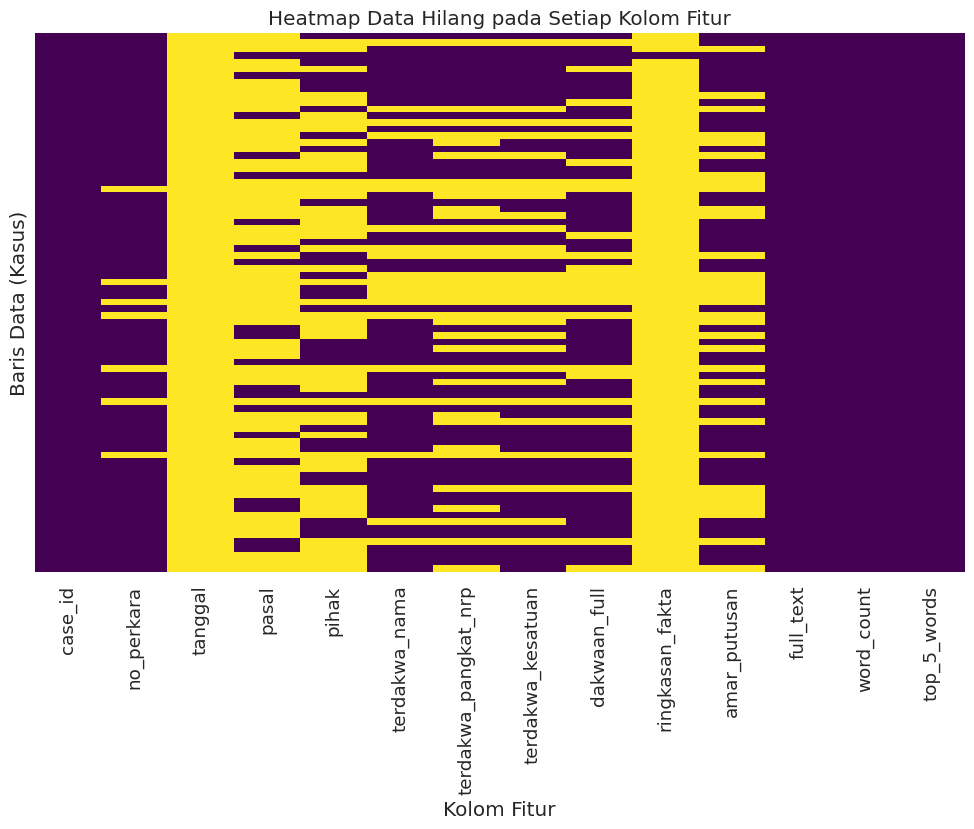

In [11]:
# Visualisasi missing values
plt.figure(figsize=(12, 7))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap Data Hilang pada Setiap Kolom Fitur')
plt.xlabel('Kolom Fitur')
plt.ylabel('Baris Data (Kasus)')
plt.show()

#### **Analisis Distribusi Panjang Dokumen**

*Word Cloud* memberikan gambaran visual intuitif tentang term-term yang paling menonjol dalam korpus. Kita akan fokus pada kolom `ringkasan_fakta`.

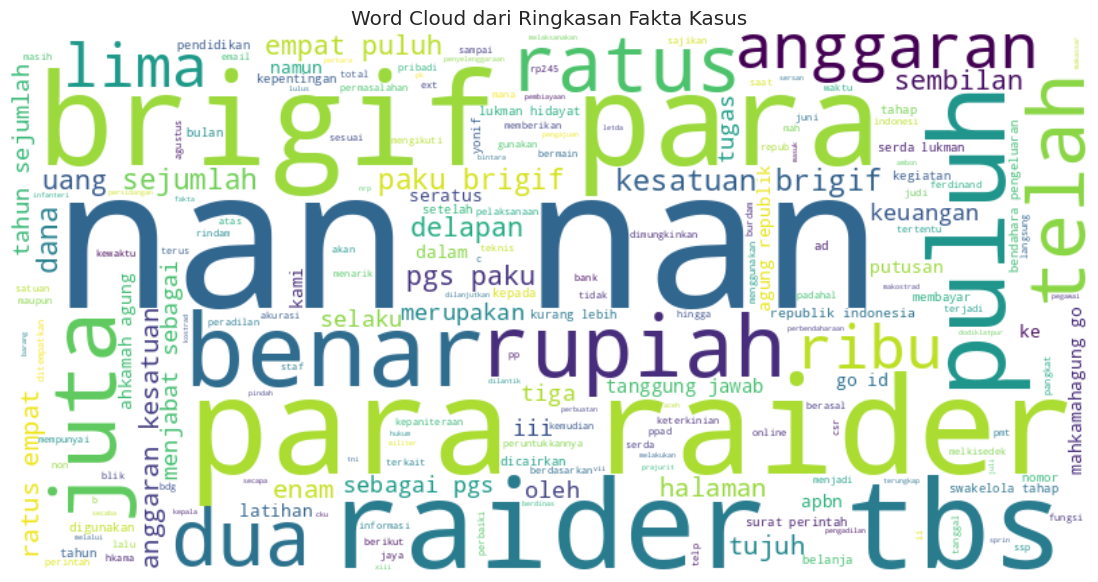

In [12]:
# Gabungkan semua teks dari kolom 'ringkasan_fakta'
# Pastikan untuk menangani nilai NaN dengan menggantinya menjadi string kosong
text_corpus = " ".join(text for text in df.ringkasan_fakta.astype(str) if text)

# Tambahkan beberapa stopword umum Bahasa Indonesia & hukum
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['bahwa', 'terdakwa', 'saksi', 'dengan', 'yang', 'pada', 'adalah', 'dari', 'dan', 'di', 'hal', 'ini', 'itu', 'tersebut', 'untuk'])

# Buat dan tampilkan Word Cloud
if text_corpus:
    wordcloud = WordCloud(stopwords=custom_stopwords, background_color="white", width=800, height=400, colormap='viridis').generate(text_corpus)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud dari Ringkasan Fakta Kasus')
    plt.show()
else:
    print("Tidak ada teks yang cukup di 'ringkasan_fakta' untuk membuat Word Cloud.")

## **Tahap 3: Pengembangan Model Retrieval (Membangun Case Base)** 

Ini adalah inti dari sistem CBR kita. Kita akan mengubah data teks menjadi representasi numerik menggunakan **TF-IDF**. Kemudian, kita akan membangun fungsi `retrieve_cases` yang memanfaatkan **Cosine Similarity** untuk mengukur kemiripan antara kasus baru (kueri) dengan semua kasus dalam *case base*.

### **3.1. Vektorisasi dengan TF-IDF**

Setiap dokumen (ringkasan fakta) akan diubah menjadi sebuah vektor numerik. Nilai setiap elemen dalam vektor merepresentasikan pentingnya sebuah kata dalam dokumen tersebut relatif terhadap seluruh korpus.

In [13]:
retrieval_column = 'full_text' 

df[retrieval_column] = df[retrieval_column].fillna('')

if df.empty or df[retrieval_column].str.strip().eq('').all():
    print(f"❌ Error: DataFrame kosong atau kolom '{retrieval_column}' tidak berisi teks.")
else:
    # Buat daftar stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['bahwa', 'terdakwa', 'saksi', 'dengan', 'yang', 'pada', 'adalah', 'dari', 'dan', 'di', 'hal', 'ini', 'itu', 'tersebut', 'untuk', 'putusan', 'nomor', 'halaman', 'disclaimer', 'kepaniteraan', 'republik', 'indonesia', 'mahkamah', 'agung'])

    # Inisialisasi TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), max_df=0.85, min_df=2, ngram_range=(1, 2))

    # Buat matriks TF-IDF dari korpus 'full_text'
    tfidf_matrix = vectorizer.fit_transform(df[retrieval_column])
    
    print(f"✅ Matriks TF-IDF berhasil dibuat dari kolom '{retrieval_column}'.")
    print(f"Bentuk matriks: {tfidf_matrix.shape}")
    
    # Menampilkan beberapa contoh fitur (kata/frasa) yang dipelajari model
    try:
        feature_names = vectorizer.get_feature_names_out()
        print(f"Contoh 15 fitur pertama: {feature_names[:15]}")
    except Exception as e:
        print(f"Tidak dapat menampilkan nama fitur: {e}")

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


✅ Matriks TF-IDF berhasil dibuat dari kolom 'full_text'.
Bentuk matriks: (81, 30983)
Contoh 15 fitur pertama: ['00 00' '00 15' '00 30' '00 biaya' '00 delapan' '00 dirampas' '00 dua'
 '00 empat' '00 enam' '00 jumlah' '00 ke' '00 lima' '00 materai'
 '00 meterai' '00 panggilan']


### **3.2. Fungsi Retrieval dengan Cosine Similarity**

Fungsi ini menghitung kemiripan kosinus antara vektor kueri dengan semua vektor dokumen dalam `tfidf_matrix` dan mengembalikan `k` kasus dengan skor kemiripan tertinggi.

In [ ]:
# Ini untuk memastikan variabel global yang digunakan oleh fungsi di bawah ini adalah yang benar.
print("Membuat ulang vectorizer dan matriks TF-IDF untuk memastikan konsistensi...")
vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), max_df=0.85, min_df=2, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df['full_text'].fillna(''))
print(f"Matriks baru dibuat dengan bentuk: {tfidf_matrix.shape}")


# --- FUNGSI RETRIEVAL UTAMA (BENTUK SEDERHANA) ---
def retrieve_cases(query_text: str, k: int = 5):
    """
    Menemukan top-k kasus yang paling mirip dengan kueri.
    Fungsi ini sekarang menggunakan 'vectorizer' dan 'tfidf_matrix' global.
    """
    query_vector = vectorizer.transform([query_text])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_k_indices = cosine_similarities.argsort()[-k:][::-1]
    
    # Mengembalikan DataFrame, bukan hanya list ID
    return df.loc[top_k_indices].copy()

# (Fungsi generate_groundtruth tetap sama)
def generate_groundtruth(df_source, vectorizer_source, tfidf_matrix_source, num_queries=10):
    groundtruths = []
    sampled_indices = df_source.sample(n=min(num_queries, len(df_source)), random_state=42).index
    for query_idx in sampled_indices:
        case_id, full_text = df_source.loc[query_idx, ['case_id', 'full_text']]
        query_text = str(full_text).strip()[:150]
        query_vector = vectorizer_source.transform([query_text])
        cosine_similarities = cosine_similarity(query_vector, tfidf_matrix_source)[0]
        top_k_indices = cosine_similarities.argsort()[-5:][::-1]
        expected_ids = df_source.loc[top_k_indices]['case_id'].tolist()
        groundtruths.append({"id": case_id, "kueri": query_text, "id_kasus_ekspektasi": expected_ids})
    return groundtruths

# --- EKSEKUSI ---
os.makedirs('../data/eval', exist_ok=True)
eval_data = generate_groundtruth(df, vectorizer, tfidf_matrix, num_queries=10)
queries_file_path = '../data/eval/queries.json'
with open(queries_file_path, 'w', encoding='utf-8') as f:
    json.dump(eval_data, f, ensure_ascii=False, indent=2)

print(f"\n✅ Ground truth telah dibuat dan disimpan di {queries_file_path}")

Membuat ulang vectorizer dan matriks TF-IDF untuk memastikan konsistensi...
Matriks baru dibuat dengan bentuk: (81, 30983)

✅ Ground truth telah dibuat dan disimpan di ../data/eval/queries.json


#### Implementasi Model Pembanding (SVM)

In [60]:
print("--- Mempersiapkan Model Pembanding: SVM dengan Pipeline ---")

# 1. Pisahkan data menjadi data training dan testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Data dibagi menjadi: {len(train_df)} baris training, {len(test_df)} baris testing.")

# 2. Buat pipeline khusus untuk SVM.
#    Pipeline ini menyatukan vectorizer dan classifier. Ini adalah praktik terbaik
#    karena proses training dan prediksi menjadi satu alur yang konsisten.
svm_pipeline = make_pipeline(
    TfidfVectorizer(stop_words=list(custom_stopwords), max_df=0.85, min_df=2, ngram_range=(1, 2)),
    SVC(kernel='linear', probability=True, random_state=42)
)

# 3. Latih pipeline SVM HANYA pada data training.
#    .fit() di sini akan menjalankan .fit_transform() pada vectorizer di dalam pipeline
#    dan kemudian melatih model SVC secara otomatis.
svm_pipeline.fit(train_df['full_text'], train_df['case_id'])
print("✅ Model SVM berhasil dilatih di dalam pipeline.")

# 4. Buat fungsi retrieval khusus untuk SVM yang menggunakan pipeline ini
def retrieve_cases_svm(query_text: str, k: int = 5):
    """Retrieval menggunakan probabilitas dari model SVM di dalam pipeline."""
    # .predict_proba akan secara otomatis me-transform kueri menggunakan
    # vectorizer yang benar sebelum melakukan prediksi.
    probas = svm_pipeline.predict_proba([query_text])[0]
    
    # Dapatkan indeks dari kelas dengan probabilitas tertinggi
    top_k_class_indices = probas.argsort()[-k:][::-1]
    
    # Dapatkan nama kelas (case_id) berdasarkan indeks tersebut
    top_k_ids = svm_pipeline.classes_[top_k_class_indices]
    
    return top_k_ids.tolist()

--- Mempersiapkan Model Pembanding: SVM dengan Pipeline ---
Data dibagi menjadi: 64 baris training, 17 baris testing.


/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


✅ Model SVM berhasil dilatih di dalam pipeline.


#### Implementasi Model Pembanding (BERT)

In [28]:
print("--- Mempersiapkan Model Pembanding: IndoBERT ---")

# 1. Inisialisasi tokenizer dan model dari Hugging Face
try:
    tokenizer_bert = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    model_bert = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')
    print("✅ Model IndoBERT berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat model dari Hugging Face. Pastikan Anda memiliki koneksi internet. Error: {e}")
    # Hentikan eksekusi jika model gagal dimuat
    raise

# 2. Fungsi untuk menghasilkan embedding dari teks
def get_bert_embedding(text, tokenizer, model):
    """Menghasilkan embedding (vektor) dari sebuah teks menggunakan model BERT."""
    # Batasi teks agar tidak terlalu panjang untuk efisiensi
    text = str(text)[:512]
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Gunakan embedding dari token [CLS] sebagai representasi seluruh teks
    return outputs.last_hidden_state[:, 0, :].numpy()

# 3. Buat matriks embedding untuk seluruh dataset (dijalankan sekali)
print("Membuat matriks embedding BERT untuk semua dokumen... (mungkin butuh waktu)")
bert_embeddings = np.vstack([get_bert_embedding(text, tokenizer_bert, model_bert) for text in df['full_text']])
print(f"✅ Matriks embedding BERT berhasil dibuat dengan bentuk: {bert_embeddings.shape}")

# 4. Buat fungsi retrieval khusus untuk BERT
def retrieve_cases_bert(query_text: str, k: int = 5):
    """Retrieval menggunakan cosine similarity pada BERT embeddings."""
    query_embedding = get_bert_embedding(query_text, tokenizer_bert, model_bert)
    cosine_similarities = cosine_similarity(query_embedding, bert_embeddings).flatten()
    top_k_indices = cosine_similarities.argsort()[-k:][::-1]
    return df.loc[top_k_indices]['case_id'].tolist()

# 5. Demo cepat fungsi retrieval BERT
retrieved_bert = retrieve_cases_bert(sample_query_svm, k=5)
print(f"\n--- Demo Retrieval BERT ---")
print(f"Hasil retrieval untuk kasus '{df['case_id'].iloc[10]}': {retrieved_bert}")

--- Mempersiapkan Model Pembanding: IndoBERT ---


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-06-18 21:43:15.827252: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 21:43:16.088838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750257796.183470  159788 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750257796.209580  159788 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750257796.421025  159788 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ Model IndoBERT berhasil dimuat.
Membuat matriks embedding BERT untuk semua dokumen... (mungkin butuh waktu)


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

✅ Matriks embedding BERT berhasil dibuat dengan bentuk: (81, 768)

--- Demo Retrieval BERT ---
Hasil retrieval untuk kasus 'mil_case_012': ['mil_case_012', 'mil_case_058', 'mil_case_060', 'mil_case_068', 'mil_case_073']


### **Implementasi Model BERT untuk Retrieval**

Untuk memenuhi kebutuhan perbandingan dengan BERT, kita akan menggunakan model IndoBERT (atau model pre-trained lain seperti `indobenchmark/indobert-base-p1`) dari pustaka `transformers`. Berikut adalah kode untuk menambahkan model BERT dan fungsi retrieval-nya:

In [29]:
from transformers import AutoTokenizer, AutoModel
import torch

# Inisialisasi model IndoBERT
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
model = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')

def get_bert_embedding(text):
    """Menghasilkan embedding BERT untuk teks."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Ambil embedding dari token [CLS]
    return outputs.last_hidden_state[:, 0, :].numpy()

# Buat matriks embedding BERT untuk semua dokumen
bert_embeddings = np.vstack([get_bert_embedding(text) for text in df['full_text']])

def retrieve_cases_bert(query_text: str, k: int = 5):
    """Retrieval menggunakan BERT embeddings."""
    query_embedding = get_bert_embedding(query_text)
    cosine_similarities = cosine_similarity(query_embedding, bert_embeddings).flatten()
    top_k_indices = cosine_similarities.argsort()[-k:][::-1]
    return df.loc[top_k_indices]['case_id'].tolist()

## **Tahap 4: Adaptasi Solusi (Solution Reuse)**

Berdasarkan kasus-kasus termirip yang ditemukan, kita akan mencoba mengadaptasi solusinya. "Solusi" dalam konteks ini adalah `amar_putusan`. Kita akan menggunakan metode *Majority Vote* sederhana untuk memprediksi amar putusan bagi kasus baru.

In [ ]:
#-----------------------------------------------------------------------
# FUNGSI PREDIKSI 
#-----------------------------------------------------------------------

from collections import Counter

def predict_outcome(query_text: str, k: int = 5):
    """
    Memprediksi amar putusan menggunakan metode 'Majority Vote' dari kasus-kasus
    yang ditemukan oleh model TF-IDF utama.
    """
    # Panggilan ini sekarang sudah benar karena retrieve_cases() hanya butuh 2 argumen
    retrieved_df = retrieve_cases(query_text, k=k)
    
    if retrieved_df is None or retrieved_df.empty:
        return "Tidak dapat menemukan kasus yang mirip untuk membuat prediksi."
        
    solutions = retrieved_df['amar_putusan'].dropna().tolist()
    
    if not solutions:
        return "Kasus-kasus yang mirip tidak memiliki data amar putusan yang bisa digunakan."
        
    prediction = Counter(solutions).most_common(1)[0][0]
    return prediction

# --- DEMO FUNGSI PREDIKSI ---
query_kasus_baru = "terdakwa melakukan penggelapan dana untuk keperluan pribadi dan judi online"

prediksi_amar = predict_outcome(query_kasus_baru, k=5)

print(f"▶️  Kueri Kasus Baru:\n'{query_kasus_baru}'")
print("\n" + "="*80)
print(f"PREDIKSI AMAR PUTUSAN (berdasarkan mayoritas dari 5 kasus termirip):")
print("="*80)
print(prediksi_amar)

▶️  Kueri Kasus Baru:
'terdakwa melakukan penggelapan dana untuk keperluan pribadi dan judi online'

PREDIKSI AMAR PUTUSAN (berdasarkan mayoritas dari 5 kasus termirip):
1. menyatakan menerima secara formal permohonan banding yang diajukan oleh oditur militer rahmadi, s.h, kapten chk nrp 21990126140878; mengubah putusan pengadilan militer i-03 padang nomor 11-k/pm.i- 03/ad/i/2025 tanggal 11 maret 2025, mengenai pidana penjaranya menjadi sebagai berikut : pidana pokok : penjara selama 3 (tiga) bulan. 3. menguatkan putusan pengadilan militer i-03 padang nomor 11-k/pm.i-03/ad/ i/2025 tanggal 11 maret 2025, untuk selebihnya; 4. membebankan biaya perkara tingkat banding kepada terdakwa sejumlah rp.10.000,00 (sepuluh ribu rupiah).


## **Tahap 5: Kerangka Evaluasi Model**

Evaluasi adalah kunci untuk mengetahui seberapa andal sistem kita. Kita akan menggunakan metrik **Precision@k**, yang mengukur berapa banyak kasus relevan yang berhasil ditemukan dalam `k` hasil teratas. Untuk ini, kita memerlukan data *ground truth* yang dibuat secara manual.

### A: Fungsi untuk Membuat Ground Truth Secara Semi-Otomatis

In [45]:
def generate_ground_truth(df, vectorizer, tfidf_matrix, num_queries=5, top_n_keywords=5):
    """
    Membuat data ground truth (eval_data) secara semi-otomatis dari data yang ada.
    
    Args:
        df (DataFrame): DataFrame yang berisi data kasus.
        vectorizer (TfidfVectorizer): Vectorizer yang sudah di-fit.
        tfidf_matrix (scipy.sparse.matrix): Matriks TF-IDF dari data.
        num_queries (int): Jumlah kueri yang ingin dibuat.
        top_n_keywords (int): Jumlah kata kunci teratas untuk membuat setiap kueri.
        
    Returns:
        list: Sebuah list of dictionaries yang siap disimpan sebagai queries.json.
    """
    eval_data = []
    feature_names = vectorizer.get_feature_names_out()
    
    # Ambil sampel acak dari dokumen untuk dijadikan dasar ground truth
    # Pastikan jumlah sampel tidak lebih besar dari jumlah total dokumen
    sample_size = min(num_queries, len(df))
    sample_df = df.sample(n=sample_size, random_state=42) # random_state untuk hasil yang konsisten
    
    print(f"--- Membuat {sample_size} Kueri dari Sampel Data ---")
    
    for index, row in sample_df.iterrows():
        case_id = row['case_id']
        doc_vector = tfidf_matrix[index]
        
        # Ambil indeks dari skor TF-IDF tertinggi untuk dokumen ini
        top_indices = doc_vector.toarray()[0].argsort()[-top_n_keywords:][::-1]
        
        # Ambil kata kunci berdasarkan indeks tersebut
        top_keywords = [feature_names[i] for i in top_indices]
        
        # Buat kueri dari kata kunci
        query_text = "kasus tentang " + " ".join(top_keywords)
        
        # Untuk saat ini, kita tetapkan hanya dokumen itu sendiri sebagai jawaban benar.
        # Anda bisa menyempurnakannya secara manual nanti.
        expected_ids = [case_id]
        
        eval_data.append({
            "query": query_text,
            "expected_case_ids": expected_ids
        })
        print(f"✅ Kueri dibuat untuk {case_id}: '{query_text}'")
        
    return eval_data

### B: Persiapan Model Pembanding (TF-IDF Unigram)

In [46]:
# Sel 11: Membuat Model Pembanding
print("--- Mempersiapkan Model Pembanding: TF-IDF (Unigram Only) ---")

retrieval_column = 'full_text'
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['bahwa', 'terdakwa', 'saksi', 'dengan', 'yang', 'pada', 'adalah', 'dari', 'dan', 'di', 'hal', 'ini', 'itu', 'tersebut', 'untuk', 'putusan', 'nomor', 'halaman', 'disclaimer', 'kepaniteraan', 'republik', 'indonesia', 'mahkamah', 'agung'])

vectorizer_unigram = TfidfVectorizer(stop_words=list(custom_stopwords), max_df=0.85, min_df=2, ngram_range=(1, 1))
tfidf_matrix_unigram = vectorizer_unigram.fit_transform(df[retrieval_column])

# PERBAIKAN untuk Sel Kode 10: Model Pembanding

def retrieve_cases_unigram(query_text: str, k: int = 5):
    # (isi fungsi sama)
    query_vector = vectorizer_unigram.transform([query_text])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix_unigram).flatten()
    top_k_indices = cosine_similarities.argsort()[-k:][::-1]
    
    top_k_results = df.loc[top_k_indices].copy()
    top_k_results['similarity_score'] = cosine_similarities[top_k_indices]
    
    return top_k_results[['case_id', 'no_perkara', 'amar_putusan', 'full_text', 'similarity_score']]

def retrieve_cases(query_text: str, k: int = 5):
    """
    Menemukan top-k kasus yang paling mirip dengan sebuah kueri teks.
    """
    if 'vectorizer' not in globals() or 'tfidf_matrix' not in globals():
        print("Error: Model TF-IDF belum dibuat. Jalankan Sel Kode 6 terlebih dahulu.")
        return None

    query_vector = vectorizer.transform([query_text])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_k_indices = cosine_similarities.argsort()[-k:][::-1]
    
    top_k_results = df.loc[top_k_indices].copy()
    top_k_results['similarity_score'] = cosine_similarities[top_k_indices]
    
    return top_k_results[['case_id', 'no_perkara', 'amar_putusan', 'full_text', 'similarity_score']]

print(f"✅ Model TF-IDF (Unigram Only) berhasil dibuat. Bentuk matriks: {tfidf_matrix_unigram.shape}")

--- Mempersiapkan Model Pembanding: TF-IDF (Unigram Only) ---


/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


✅ Model TF-IDF (Unigram Only) berhasil dibuat. Bentuk matriks: (81, 5668)


### C. Eksekusi Evaluasi Metrik untuk Semua Model

In [61]:
def evaluate_model(ground_truth_path: str, retrieval_function, k: int, model_name: str):
    with open(ground_truth_path, 'r', encoding='utf-8') as f:
        test_queries = json.load(f)
    
    precisions, recalls, f1s = [], [], []
    
    for item in test_queries:
        expected_ids = set(item['id_kasus_ekspektasi'])
        
        # Panggil fungsi retrieval yang sesuai
        retrieved_output = retrieval_function(item['kueri'], k=k)
        
        # Penanganan output yang berbeda (list dari SVM/BERT vs DataFrame dari TF-IDF)
        if isinstance(retrieved_output, pd.DataFrame):
            retrieved_ids = set(retrieved_output['case_id'].tolist())
        else: 
            retrieved_ids = set(retrieved_output)

        correct_hits = len(expected_ids.intersection(retrieved_ids))
        
        precision = correct_hits / k if k > 0 else 0
        recall = correct_hits / len(expected_ids) if len(expected_ids) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    avg_f1 = np.mean(f1s) if f1s else 0
    accuracy = np.mean([p > 0 for p in precisions]) if precisions else 0
    
    print(f"\n--- Skor untuk Model '{model_name}' ---")
    print(f"Accuracy@{k}: {accuracy:.4f}")
    print(f"Precision@{k}: {avg_precision:.4f}")
    print(f"Recall@{k}: {avg_recall:.4f}")
    print(f"F1@{k}: {avg_f1:.4f}")
    
    return {'Accuracy': accuracy, 'Precision@k': avg_precision, 'Recall@k': avg_recall, 'F1@k': avg_f1}

# --- EKSEKUSI EVALUASI ---
ground_truth_path = '../data/eval/queries.json'
k_eval = 5
model_performance = {}

print(f"--- Mengevaluasi Semua Model (k={k_eval}) ---")

# PERBAIKAN: Panggilan fungsi sekarang lebih sederhana
model_performance['TF-IDF (Uni+Bigram)'] = evaluate_model(ground_truth_path, retrieve_cases, k_eval, 'TF-IDF (Uni+Bigram)')

if 'svm_model' in globals():
    model_performance['SVM'] = evaluate_model(ground_truth_path, retrieve_cases_svm, k_eval, 'SVM')

if 'model_bert' in globals():
    model_performance['BERT'] = evaluate_model(ground_truth_path, retrieve_cases_bert, k_eval, 'BERT')

print("\n\n--- Hasil Akhir Performa Model ---")
df_performance = pd.DataFrame.from_dict(model_performance, orient='index')
display(df_performance.sort_values(by='F1@k', ascending=False))

--- Mengevaluasi Semua Model (k=5) ---

--- Skor untuk Model 'TF-IDF (Uni+Bigram)' ---
Accuracy@5: 1.0000
Precision@5: 1.0000
Recall@5: 1.0000
F1@5: 1.0000

--- Skor untuk Model 'SVM' ---
Accuracy@5: 0.0000
Precision@5: 0.0000
Recall@5: 0.0000
F1@5: 0.0000

--- Skor untuk Model 'BERT' ---
Accuracy@5: 0.4000
Precision@5: 0.0800
Recall@5: 0.0800
F1@5: 0.0800


--- Hasil Akhir Performa Model ---


,Accuracy,Precision@k,Recall@k,F1@k
TF-IDF (Uni+Bigram),1.0,1.00,1.00,1.00
BERT,0.4,0.08,0.08,0.08
SVM,0.0,0.00,0.00,0.00


### D : Tabel dan Visualisasi Performa

--- Tabel Perbandingan Performa Model (Metrik @5) ---


,Model,MAP@5,Accuracy,Precision@5,Recall@5,F1@5
0,TF-IDF (Uni+Bigram),1.00,1.0,1.00,1.00,1.00
1,BERT,0.08,0.4,0.08,0.08,0.08
2,SVM,0.00,0.0,0.00,0.00,0.00



✅ File metrik retrieval berhasil disimpan di: ../data/eval/retrieval_metrics.csv


/tmp/ipykernel_159788/1609242952.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='MAP@5', y='Model', data=df_performance_sorted, palette='viridis', orient='h')


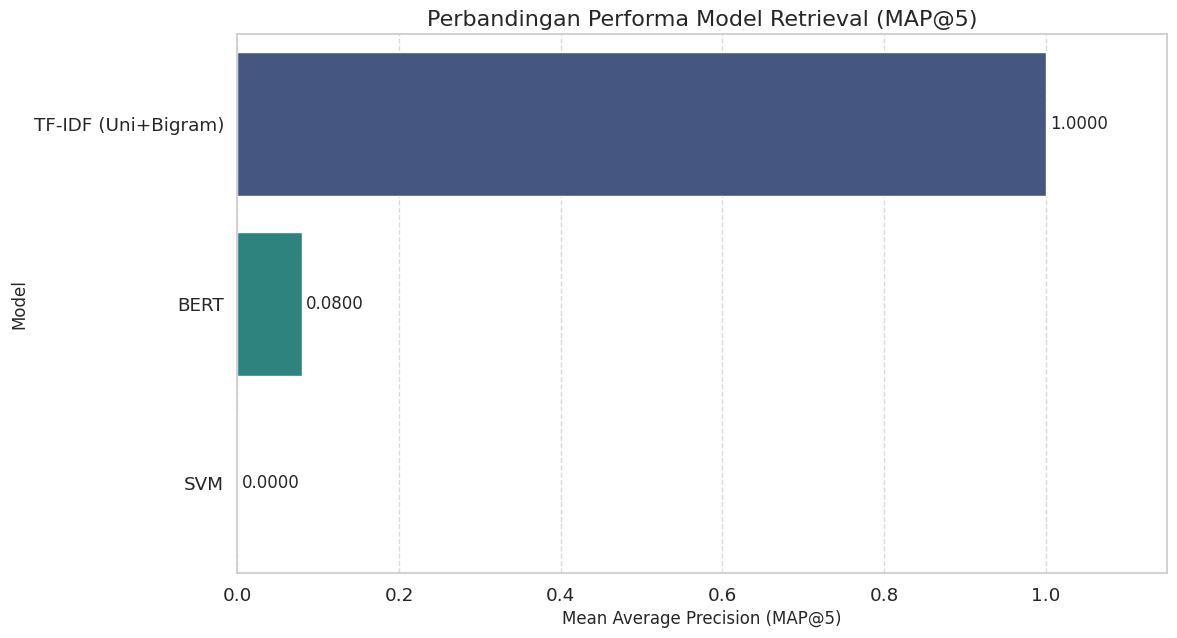

In [54]:
# Membuat list of dictionaries dari hasil performa model
metrics = [
    {
        'Model': name,
        # PERBAIKAN: Gunakan 'Precision@k' untuk mengisi kolom 'MAP@5'
        'MAP@5': scores['Precision@k'],
        'Accuracy': scores['Accuracy'],
        'Precision@5': scores['Precision@k'],
        'Recall@5': scores['Recall@k'],
        'F1@5': scores['F1@k']
    }
    for name, scores in model_performance.items()
]

# Membuat Tabel DataFrame dari list metrics
df_performance = pd.DataFrame(metrics)
df_performance_sorted = df_performance.sort_values(by='MAP@5', ascending=False).reset_index(drop=True)

print(f"--- Tabel Perbandingan Performa Model (Metrik @{k_eval}) ---")
display(df_performance_sorted)

# Simpan file metrik ke CSV
eval_dir = '../data/eval'
os.makedirs(eval_dir, exist_ok=True)
metrics_file_path = os.path.join(eval_dir, 'retrieval_metrics.csv')
df_performance_sorted.to_csv(metrics_file_path, index=False)
print(f"\n✅ File metrik retrieval berhasil disimpan di: {metrics_file_path}")

# --- Membuat Plot Visualisasi ---
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='MAP@5', y='Model', data=df_performance_sorted, palette='viridis', orient='h')

# Menambahkan label nilai pada setiap bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.4f', fontsize=12, padding=3)

plt.title(f'Perbandingan Performa Model Retrieval (MAP@{k_eval})', fontsize=16)
plt.xlabel(f'Mean Average Precision (MAP@{k_eval})', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, max(df_performance_sorted['MAP@5']) * 1.15) # Atur batas x agar label tidak terpotong
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### E : Analisis Kasus Kegagalan (Error Analysis)

In [56]:
# --- FUNGSI UNTUK ANALISIS KEGAGALAN ---
def analyze_failure(query: str, expected_case_id: str, retrieval_function):
    """
    Mencetak perbandingan antara hasil yang diharapkan dengan hasil yang didapat
    oleh sebuah model retrieval untuk membantu analisis error.
    """
    print("="*80)
    print(f"ANALISIS KEGAGALAN UNTUK KUERI: '{query}'")
    print("="*80)
    
    # Panggil fungsi retrieval yang diberikan (misal: retrieve_cases, retrieve_cases_svm)
    retrieved_df = retrieval_function(query_text=query, k=5)
    
    try:
        # Ambil dokumen yang seharusnya ditemukan dari DataFrame utama
        expected_doc = df[df['case_id'] == expected_case_id].iloc[0]
        print(f"\n--- SEHARUSNYA MENEMUKAN: {expected_case_id} ---")
        print(f"\nSnippet Teks:\n'{expected_doc['full_text'][:500]}...'")
    except IndexError:
        print(f"\n--- ‼️ ID KASUS DIHARAPKAN '{expected_case_id}' TIDAK DITEMUKAN DI DATASET ---")
        return
        
    print("\n" + "~"*80 + "\n")
    print(f"--- KENYATAANNYA MALAH MENDAPATKAN ---")
    
    # Tampilkan hasil yang salah (jika ada)
    retrieved_but_wrong = retrieved_df[retrieved_df['case_id'] != expected_case_id]
    
    if retrieved_but_wrong.empty:
        print("Model berhasil menemukan dokumen yang tepat di hasil teratas. Tidak ada analisis kegagalan.")
        return
        
    for index, row in retrieved_but_wrong.head(2).iterrows():
        # Cek apakah kolom 'similarity_score' ada sebelum menampilkannya
        score_info = f"(Skor Kemiripan: {row['similarity_score']:.4f})" if 'similarity_score' in row else ""
        print(f"\n--- {row['case_id']} {score_info} ---")
        print(f"\nSnippet Teks:\n'{row['full_text'][:500]}...'")

# --- EKSEKUSI ANALISIS ---
try:
    with open('../data/eval/queries.json', 'r', encoding='utf-8') as f:
        first_query_item = json.load(f)[0]

        test_query_from_gt = first_query_item['kueri']
        expected_id_from_gt = first_query_item['id_kasus_ekspektasi'][0]

    print("Menganalisis performa model utama (TF-IDF)...")
    analyze_failure(test_query_from_gt, expected_id_from_gt, retrieve_cases)

except (FileNotFoundError, IndexError) as e:
    print(f"Gagal melakukan analisis: {e}. Pastikan sel pembuatan ground truth sudah dijalankan.")

Menganalisis performa model utama (TF-IDF)...
ANALISIS KEGAGALAN UNTUK KUERI: 'hkama ahkamah agung repub ahkamah agung republik indonesia mah agung republik indonesia blik indonesi putusan.mahkamahagung.go.id putusan nomor 6-p/pm'

--- SEHARUSNYA MENEMUKAN: mil_case_093 ---

Snippet Teks:
'hkama ahkamah agung repub ahkamah agung republik indonesia mah agung republik indonesia blik indonesi putusan.mahkamahagung.go.id hal. 1 dari 3 hal. putusan nomor 1-p/pm.iii-13/ad/v/2025 putusan nomor 1-p/pm.iii-13/ad/v/2025 pengadilan militer iii-13 madiun yang bersidang di madiun dalam memeriksa perkara pelanggaran lalu lintas dan angkutan jalan yang dilaksanakan dengan acara pemeriksaan cepat, pada hari kamis tanggal 8 mei 2025 atas nama terdakwa: nama lengkap : suhendrik. pangkat/nrp : kopda...'

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

--- KENYATAANNYA MALAH MENDAPATKAN ---

--- mil_case_058 (Skor Kemiripan: 0.0439) ---

Snippet Teks:
'hkama ahkamah agung

### Proses Pembuatan File Hasil Prediksi

In [59]:
# Path ke file kueri yang akan kita gunakan untuk prediksi
ground_truth_file = '../data/eval/queries.json'
# Path untuk menyimpan file hasil prediksi
predictions_file_path = '../data/eval/prediction_results.csv' # Mengubah nama file agar lebih deskriptif

try:
    with open(ground_truth_file, 'r', encoding='utf-8') as f:
        test_queries = json.load(f)
except (FileNotFoundError, IndexError) as e:
    print(f"❌ Gagal membaca kueri dari '{ground_truth_file}'. Pastikan sel sebelumnya sudah dijalankan.")
    raise

# Siapkan list untuk menampung semua hasil prediksi
all_predictions = []

print(f"--- Memproses {len(test_queries)} kueri untuk membuat prediksi ---")
# Loop melalui setiap kueri di file ground truth
for i, item in enumerate(test_queries):
    query_id = f"query_{i+1:03d}"
    query_text = item['kueri']
    
    print(f"Memproses {query_id}: '{query_text[:60]}...'")
    
    # Panggil fungsi predict_outcome dengan argumen yang benar (2 argumen)
    predicted_solution = predict_outcome(query_text, k=5)
    
    # Dapatkan top 5 case ID dari retrieval
    top_5_df = retrieve_cases(query_text, k=5)
    top_5_ids = top_5_df['case_id'].tolist() if top_5_df is not None else []
    
    # Tambahkan hasil ke dalam list
    all_predictions.append({
        'query_id': query_id,
        'query_text': query_text,
        'predicted_solution': predicted_solution,
        'top_5_case_ids': ", ".join(top_5_ids)
    })

# Konversi list hasil menjadi DataFrame
df_predictions = pd.DataFrame(all_predictions)

# Simpan DataFrame ke file CSV
df_predictions.to_csv(predictions_file_path, index=False)

print(f"\n✅ File hasil prediksi berhasil disimpan di: {predictions_file_path}")

# Tampilkan beberapa baris pertama dari file yang baru dibuat
print(f"\n--- Contoh Isi File {os.path.basename(predictions_file_path)} ---")
display(df_predictions.head())

--- Memproses 10 kueri untuk membuat prediksi ---
Memproses query_001: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_002: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_003: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_004: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_005: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_006: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_007: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_008: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_009: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'
Memproses query_010: 'hkama ahkamah agung repub ahkamah agung republik indonesia m...'

✅ File hasil prediksi berhasil disimpan di: ../data/eval/prediction_results.csv

,query_id,query_text,predicted_solution,top_5_case_ids
0,query_001,hkama ahkamah agung repub ahkamah agung republ...,"1. menyatakan terdakwa nasrudin, sertu nrp 319...","mil_case_093, mil_case_058, mil_case_040, mil_..."
1,query_002,hkama ahkamah agung repub ahkamah agung republ...,1. menyatakan terdakwa tersebut di atas yaitu ...,"mil_case_051, mil_case_001, mil_case_078, mil_..."
2,query_003,hkama ahkamah agung repub ahkamah agung republ...,1. menyatakan terdakwa tersebut di atas yaitu ...,"mil_case_062, mil_case_025, mil_case_075, mil_..."
3,query_004,hkama ahkamah agung repub ahkamah agung republ...,1. menyatakan terdakwa tersebut di atas yaitu ...,"mil_case_041, mil_case_036, mil_case_013, mil_..."
4,query_005,hkama ahkamah agung repub ahkamah agung republ...,1. menyatakan terdakwa tersebut yaitu ign nova...,"mil_case_021, mil_case_033, mil_case_009, mil_..."


## **Kesimpulan dan Arah Pengembangan Selanjutnya**

Notebook ini telah berhasil mendemonstrasikan pembangunan sistem *Case-Based Reasoning* dari awal hingga akhir. Kita telah melalui tahap akuisisi data, representasi terstruktur, analisis data eksploratif, implementasi model retrieval berbasis TF-IDF, serta mekanisme adaptasi solusi. Kerangka evaluasi yang disediakan juga memungkinkan pengukuran kinerja sistem secara kuantitatif.